# Spotify API Scrape

In [1]:
# run this once
#!pip install spotipy --upgrade

In [49]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np
import json
import os

In [50]:
with open("../api_cred.json") as json_file:
    creds = json.load(json_file)

FileNotFoundError: [Errno 2] No such file or directory: '../api_cred.json'

In [51]:
client_id = "62336fe9d642490784fa7d05ac85975d"
client_secret = "faa5669c4f874c77a56f57dba4791b4c"
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [52]:
def load_cached_requests(fp):
    if os.path.exists(fp):
        with open(fp) as json_file:
            ret_dic = json.load(json_file)
            print("Loaded cached data at:",fp)
    else:
        print("Failed to load cached data at:",fp)
        ret_dic = {}
    return ret_dic

def save_cached_requests(save_dic, save_dir,fname):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    with open(save_dir+fname,'w+') as outfile:
        json.dump(save_dic,outfile)
    print("Requests Cached Successfully at:", save_dir+fname)

def save_csvs(df_list,dir_list,fname_list):
    if len(df_list) == len(dir_list) == len(fname_list):
        for i in range(len(df_list)):
            cur_df = df_list[i]
            cur_dir = dir_list[i]
            cur_fname = fname_list[i]
            if not os.path.exists(cur_dir):
                os.makedirs(cur_dir)
            cur_df.to_csv(cur_dir+cur_fname,index=False)
            print("CSV Saved at:",cur_dir+cur_fname)
    else:
        print("Save Failed: List lengths must be the same")

In [53]:
cache_dir = "../data/local/cached_requests/"
master_track_fname = "track_data.json"
master_playlist_fname = "playlist_data.json"
master_audio_features_fname = "track_audio_features.json"
master_track_dic = load_cached_requests(cache_dir + master_track_fname)
master_playlist_dic = load_cached_requests(cache_dir + master_playlist_fname)
master_audio_features_dic = load_cached_requests(cache_dir + master_audio_features_fname)

Loaded cached data at: ../data/local/cached_requests/track_data.json
Loaded cached data at: ../data/local/cached_requests/playlist_data.json
Loaded cached data at: ../data/local/cached_requests/track_audio_features.json


In [54]:
def get_playlists_data_from_category(cat_id,master_playlist_dic):
    # api call
    search_result = sp.category_playlists(category_id=cat_id,country="US")
    playlist_ids = []
    for playlist in search_result['playlists']['items']:
        playlist_ids.append(playlist['id'])
    playlists_data = []
    for playlist_id in playlist_ids:
        # avoids api call using cached request, could hold outdated info if playlist is changed recently
        if playlist_id in master_playlist_dic.keys():
            playlist_data = master_playlist_dic[playlist_id]
        else:
            # api call
            playlist_data = sp.playlist(playlist_id)
            master_playlist_dic[playlist_id] = playlist_data
        playlists_data.append(playlist_data)
    return playlists_data

In [55]:
def get_track_data_from_playlists(playlists_data, master_track_dic, master_audio_features_dic):
    ret_df = pd.DataFrame()
    for cur_playlist_data in playlists_data: # only doing two for api reasons currently

        # can add more features here (album, artist, etc..) MOVED TO FUNCTION USING CACHED DICS
        cur_playlist_track_ids = []
        for track in cur_playlist_data['tracks']['items']:
            if track['track']:
                cur_track_id = track['track']['id']
                if cur_track_id != None:
                    # caches track metadata if not cached
                    if cur_track_id not in master_track_dic.keys():
                        master_track_dic[cur_track_id] = track
                    cur_playlist_track_ids.append(cur_track_id)
                
        # making a list of non cached track audio features
        not_cached_ids = []
        for track_id in cur_playlist_track_ids:
            if track_id not in master_audio_features_dic.keys():
                not_cached_ids.append(track_id)

        # get audio features of non cached tracks
        if len(not_cached_ids) > 0:
            print("Making",len(not_cached_ids),"API Calls")
            # api call
            not_cached_data = sp.audio_features(not_cached_ids)
            # caching the non cached track audio features
            for i in range(len(not_cached_data)):
                track_feats = not_cached_data[i]
                if track_feats:
                    master_audio_features_dic[track_feats['id']] = track_feats
                else:
                    master_audio_features_dic[not_cached_ids[i]] = None

        # iterating current playlist tracks and accessing the cached audio features
        playlist_track_feats = []
        for track_id in cur_playlist_track_ids:
            cur_feats = master_audio_features_dic[track_id]
            if cur_feats:
                playlist_track_feats.append(cur_feats)

        # building return df
        cur_playlist_df = pd.DataFrame(playlist_track_feats)
        ret_df = pd.concat([ret_df, cur_playlist_df])
    ret_df = ret_df.reset_index(drop=True)
    return ret_df

In [56]:
kpop_playlists_data = get_playlists_data_from_category("kpop",master_playlist_dic)
kpop_df = get_track_data_from_playlists(kpop_playlists_data, master_track_dic,master_audio_features_dic)

pop_playlists_data = get_playlists_data_from_category("pop",master_playlist_dic)
pop_df = get_track_data_from_playlists(pop_playlists_data, master_track_dic,master_audio_features_dic)

rock_playlists_data = get_playlists_data_from_category("rock",master_playlist_dic)
rock_df = get_track_data_from_playlists(rock_playlists_data, master_track_dic,master_audio_features_dic)

Making 65 API Calls


In [57]:
save_cached_requests(master_track_dic,cache_dir,master_track_fname)
save_cached_requests(master_playlist_dic,cache_dir,master_playlist_fname)
save_cached_requests(master_audio_features_dic,cache_dir,master_audio_features_fname)

Requests Cached Successfully at: ../data/local/cached_requests/track_data.json
Requests Cached Successfully at: ../data/local/cached_requests/playlist_data.json
Requests Cached Successfully at: ../data/local/cached_requests/track_audio_features.json


In [58]:
kpop_csv_dir = "../data/test/kpop/metadata/"
kpop_fname = "kpop_metadata.csv"

pop_csv_dir = "../data/test/pop/metadata/"
pop_fname = "pop_metadata.csv"

rock_csv_dir = "../data/test/rock/metadata/"
rock_fname = "rock_metadata.csv"

dfs = [kpop_df,pop_df,rock_df]
csv_dirs = [kpop_csv_dir,pop_csv_dir,rock_csv_dir]
csv_fnames = [kpop_fname,pop_fname,rock_fname]

save_csvs(dfs,csv_dirs,csv_fnames)

CSV Saved at: ../data/test/kpop/metadata/kpop_metadata.csv
CSV Saved at: ../data/test/pop/metadata/pop_metadata.csv
CSV Saved at: ../data/test/rock/metadata/rock_metadata.csv


In [59]:
import matplotlib.pyplot as plt

In [60]:
kpop = pd.read_csv("../data/test/kpop/metadata/kpop_metadata.csv")
pop = pd.read_csv("../data/test/pop/metadata/pop_metadata.csv")
rock = pd.read_csv("../data/test/rock/metadata/rock_metadata.csv")

In [61]:
rock

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.520,0.856,2,-4.228,1,0.0806,0.000193,0.000000,0.1570,0.470,160.083,audio_features,1bWEngw5tAF7vWByrf5Oy5,spotify:track:1bWEngw5tAF7vWByrf5Oy5,https://api.spotify.com/v1/tracks/1bWEngw5tAF7...,https://api.spotify.com/v1/audio-analysis/1bWE...,205016,4
1,0.500,0.949,1,-3.123,1,0.0833,0.008470,0.000000,0.5140,0.648,159.824,audio_features,7noHzxuNmeIwYftylZfVRT,spotify:track:7noHzxuNmeIwYftylZfVRT,https://api.spotify.com/v1/tracks/7noHzxuNmeIw...,https://api.spotify.com/v1/audio-analysis/7noH...,175343,4
2,0.369,0.845,0,-3.449,0,0.0611,0.049300,0.000000,0.4160,0.782,78.532,audio_features,0tyR7Bu9P086aWBFZ4QJoo,spotify:track:0tyR7Bu9P086aWBFZ4QJoo,https://api.spotify.com/v1/tracks/0tyR7Bu9P086...,https://api.spotify.com/v1/audio-analysis/0tyR...,174068,4
3,0.549,0.741,2,-3.711,1,0.0325,0.000423,0.000715,0.2980,0.420,140.017,audio_features,4Fj6KslSYYQ1kAbafiKoz0,spotify:track:4Fj6KslSYYQ1kAbafiKoz0,https://api.spotify.com/v1/tracks/4Fj6KslSYYQ1...,https://api.spotify.com/v1/audio-analysis/4Fj6...,236347,4
4,0.507,0.883,0,-3.553,1,0.0424,0.002090,0.073700,0.0728,0.386,103.074,audio_features,47RUKAN9BY0z6lZcs9rCsw,spotify:track:47RUKAN9BY0z6lZcs9rCsw,https://api.spotify.com/v1/tracks/47RUKAN9BY0z...,https://api.spotify.com/v1/audio-analysis/47RU...,245867,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609,0.650,0.798,9,-8.126,0,0.0541,0.441000,0.000706,0.1370,0.464,110.646,audio_features,3XrPNRdFbGZESTGPte23dD,spotify:track:3XrPNRdFbGZESTGPte23dD,https://api.spotify.com/v1/tracks/3XrPNRdFbGZE...,https://api.spotify.com/v1/audio-analysis/3XrP...,213707,4
1610,0.527,0.871,4,-8.708,1,0.0354,0.022900,0.155000,0.4190,0.107,120.722,audio_features,672N8DGGTOLCOgWe0koX5g,spotify:track:672N8DGGTOLCOgWe0koX5g,https://api.spotify.com/v1/tracks/672N8DGGTOLC...,https://api.spotify.com/v1/audio-analysis/672N...,188560,4
1611,0.682,0.621,7,-9.653,1,0.0451,0.025000,0.852000,0.1530,0.861,125.910,audio_features,2J9GLqNATExevUPvpLU1Sl,spotify:track:2J9GLqNATExevUPvpLU1Sl,https://api.spotify.com/v1/tracks/2J9GLqNATExe...,https://api.spotify.com/v1/audio-analysis/2J9G...,279520,4
1612,0.364,0.768,9,-10.492,1,0.0757,0.210000,0.136000,0.5030,0.370,130.602,audio_features,2BGNomqCxEDcXyxf8bg27k,spotify:track:2BGNomqCxEDcXyxf8bg27k,https://api.spotify.com/v1/tracks/2BGNomqCxEDc...,https://api.spotify.com/v1/audio-analysis/2BGN...,214640,4


In [62]:
# kpop's data
kpop_min = min(kpop['danceability'])
kpop_max = max(kpop['danceability'])
kpop_avg = np.mean(kpop['danceability'])
kpop_sd = np.std(kpop['danceability'])

print('Min: ', kpop_min, '\nMax: ', kpop_max, '\nAverage: ', kpop_avg, '\nStandard Deviation: ', kpop_sd)

Min:  0.212 
Max:  0.961 
Average:  0.6344809027777778 
Standard Deviation:  0.13540111314480271


(array([  5.,  34.,  85.,  92., 151., 218., 281., 221.,  50.,  15.]),
 array([0.212 , 0.2869, 0.3618, 0.4367, 0.5116, 0.5865, 0.6614, 0.7363,
        0.8112, 0.8861, 0.961 ]),
 <a list of 10 Patch objects>)

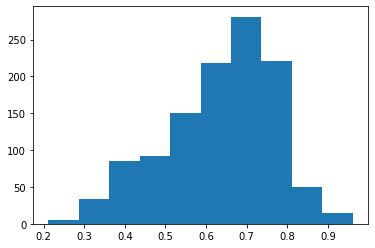

In [63]:
plt.hist(kpop['danceability'])

In [64]:
# kpop's data
kpop_min = min(kpop['acousticness'])
kpop_max = max(kpop['acousticness'])
kpop_avg = np.mean(kpop['acousticness'])
kpop_sd = np.std(kpop['acousticness'])

print('Min: ', kpop_min, '\nMax: ', kpop_max, '\nAverage: ', kpop_avg, '\nStandard Deviation: ', kpop_sd)

Min:  0.000252 
Max:  0.992 
Average:  0.32610139322916676 
Standard Deviation:  0.30063806978497226


In [65]:
# pop's data
pop_min = min(pop['acousticness'])
pop_max = max(pop['acousticness'])
pop_avg = np.mean(pop['acousticness'])
pop_sd = np.std(pop['acousticness'])

print('Min: ', pop_min, '\nMax: ', pop_max, '\nAverage: ', pop_avg, '\nStandard Deviation: ', pop_sd)

Min:  6.790000000000001e-05 
Max:  0.9790000000000001 
Average:  0.26948260500618065 
Standard Deviation:  0.26409580456158704


(array([ 15.,  25.,  65., 133., 216., 316., 376., 266., 144.,  62.]),
 array([0.209, 0.286, 0.363, 0.44 , 0.517, 0.594, 0.671, 0.748, 0.825,
        0.902, 0.979]),
 <a list of 10 Patch objects>)

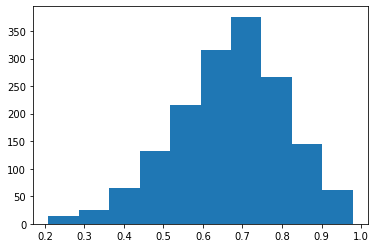

In [66]:
plt.hist(pop['danceability'])

In [67]:
# rock's data
rock_min = min(rock['acousticness'])
rock_max = max(rock['acousticness'])
rock_avg = np.mean(rock['acousticness'])
rock_sd = np.std(rock['acousticness'])

print('Min: ', rock_min, '\nMax: ', rock_max, '\nAverage: ', rock_avg, '\nStandard Deviation: ', rock_sd)

Min:  1.47e-06 
Max:  0.914 
Average:  0.13465978030978903 
Standard Deviation:  0.1989550207456263


(array([ 11.,  60., 120., 238., 383., 369., 256., 125.,  46.,   6.]),
 array([0.104 , 0.1869, 0.2698, 0.3527, 0.4356, 0.5185, 0.6014, 0.6843,
        0.7672, 0.8501, 0.933 ]),
 <a list of 10 Patch objects>)

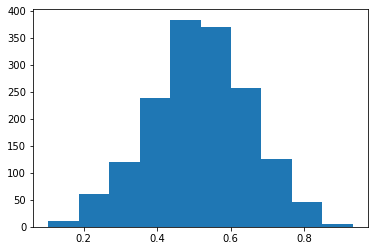

In [68]:
plt.hist(rock['danceability'])

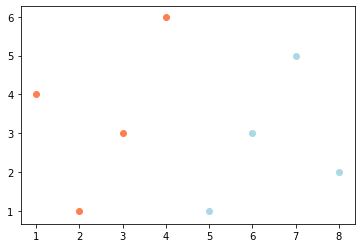

In [69]:
x = [1,2,3,4]
y = [4,1,3,6]

plt.scatter(x, y, c='coral')

x = [5,6,7,8]
y = [1,3,5,2]

plt.scatter(x, y, c='lightblue')

plt.show()

In [70]:
np.median(kpop['danceability'])

0.6585

In [71]:
# sampling 50 from each dataframe
kpop['genre'] = 'kpop'
pop['genre'] = 'pop'
rock['genre'] = 'rock'

kpop_sample = kpop.sample(200)
pop_sample = pop.sample(200)
rock_sample = rock.sample(200)

df = [kpop_sample, pop_sample, rock_sample]
analysis_df = pd.concat(df, ignore_index = True)
analysis_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre
0,0.671,0.859,4,-3.922,0,0.0833,0.032300,0.000000,0.2670,0.389,139.931,audio_features,7b8YOVV5quZcSKEijDgyWB,spotify:track:7b8YOVV5quZcSKEijDgyWB,https://api.spotify.com/v1/tracks/7b8YOVV5quZc...,https://api.spotify.com/v1/audio-analysis/7b8Y...,209355,4,kpop
1,0.726,0.716,9,-4.089,1,0.0369,0.214000,0.000000,0.1000,0.174,102.002,audio_features,5IahLTZCuGKj1Iz2Q0Zwuv,spotify:track:5IahLTZCuGKj1Iz2Q0Zwuv,https://api.spotify.com/v1/tracks/5IahLTZCuGKj...,https://api.spotify.com/v1/audio-analysis/5Iah...,229000,4,kpop
2,0.824,0.450,5,-7.408,1,0.3210,0.185000,0.000002,0.1000,0.470,95.056,audio_features,0nP9JFMx8z5QNl5Ph8ExEa,spotify:track:0nP9JFMx8z5QNl5Ph8ExEa,https://api.spotify.com/v1/tracks/0nP9JFMx8z5Q...,https://api.spotify.com/v1/audio-analysis/0nP9...,141291,4,kpop
3,0.667,0.234,9,-11.909,1,0.0306,0.928000,0.000033,0.1490,0.142,101.929,audio_features,2XdyebP7KxClMOse2C5iyA,spotify:track:2XdyebP7KxClMOse2C5iyA,https://api.spotify.com/v1/tracks/2XdyebP7KxCl...,https://api.spotify.com/v1/audio-analysis/2Xdy...,270002,4,kpop
4,0.787,0.543,10,-6.700,0,0.0370,0.023300,0.000000,0.0861,0.332,99.026,audio_features,0ErzcmZ2gIwX7X0xSMQPix,spotify:track:0ErzcmZ2gIwX7X0xSMQPix,https://api.spotify.com/v1/tracks/0ErzcmZ2gIwX...,https://api.spotify.com/v1/audio-analysis/0Erz...,210641,4,kpop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.503,0.470,0,-8.006,1,0.0257,0.291000,0.000000,0.3960,0.334,108.486,audio_features,6Nq8YtPAHuL1outooeiFde,spotify:track:6Nq8YtPAHuL1outooeiFde,https://api.spotify.com/v1/tracks/6Nq8YtPAHuL1...,https://api.spotify.com/v1/audio-analysis/6Nq8...,241373,4,rock
596,0.494,0.666,9,-9.743,0,0.0351,0.229000,0.000057,0.0469,0.699,140.832,audio_features,0AiuEo7FCxP2y2WTOpLPe5,spotify:track:0AiuEo7FCxP2y2WTOpLPe5,https://api.spotify.com/v1/tracks/0AiuEo7FCxP2...,https://api.spotify.com/v1/audio-analysis/0Aiu...,147893,4,rock
597,0.496,0.682,8,-4.095,1,0.0294,0.005520,0.000029,0.0589,0.474,167.060,audio_features,5GorCbAP4aL0EJ16frG2hd,spotify:track:5GorCbAP4aL0EJ16frG2hd,https://api.spotify.com/v1/tracks/5GorCbAP4aL0...,https://api.spotify.com/v1/audio-analysis/5Gor...,262333,4,rock
598,0.526,0.762,0,-12.437,0,0.0342,0.000972,0.000116,0.3380,0.505,136.203,audio_features,263aNAQCeFSWipk896byo6,spotify:track:263aNAQCeFSWipk896byo6,https://api.spotify.com/v1/tracks/263aNAQCeFSW...,https://api.spotify.com/v1/audio-analysis/263a...,214400,4,rock


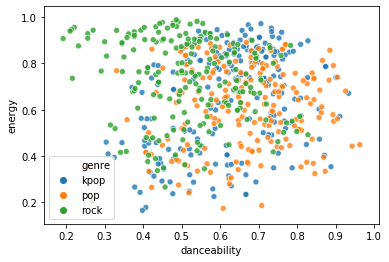

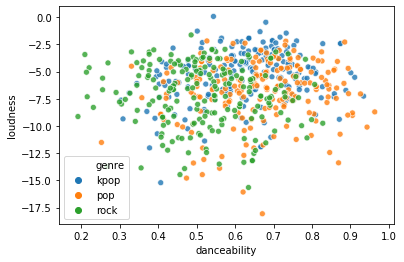

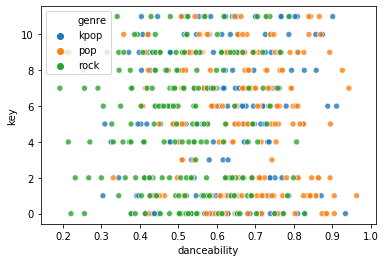

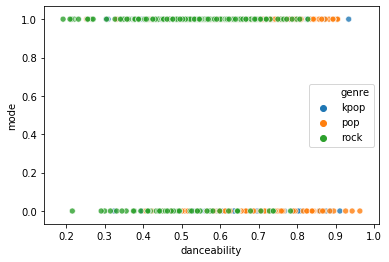

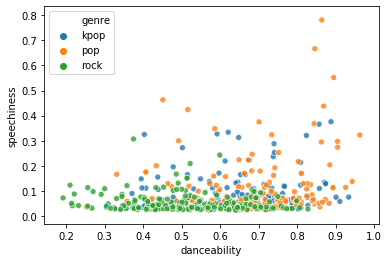

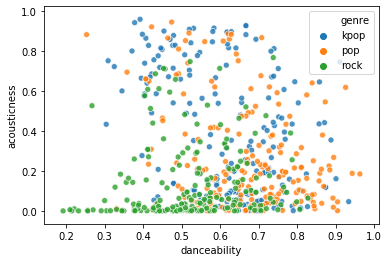

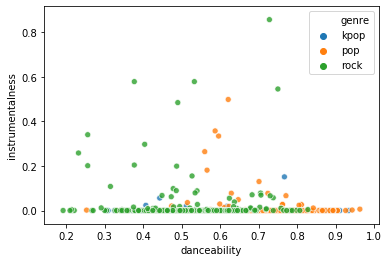

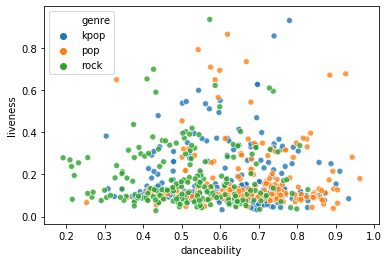

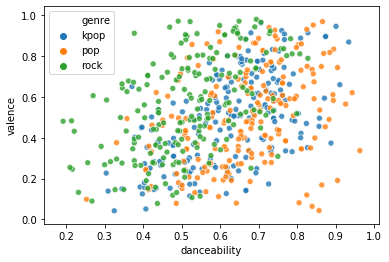

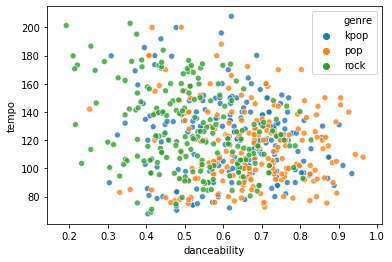

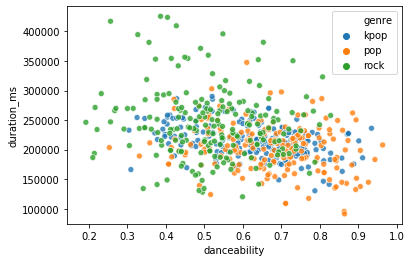

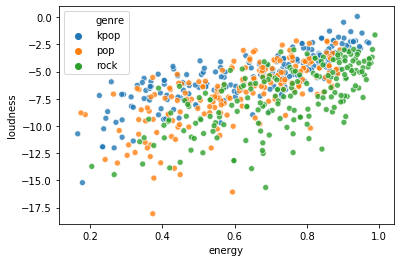

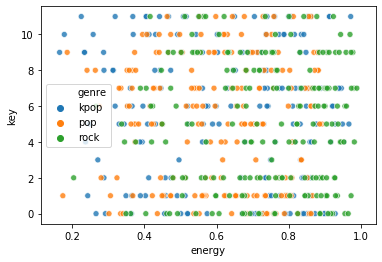

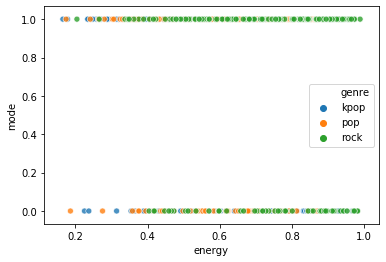

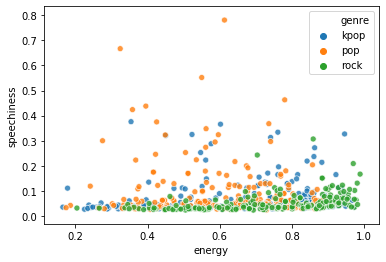

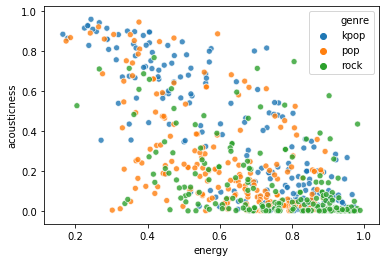

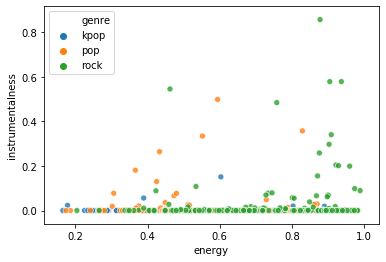

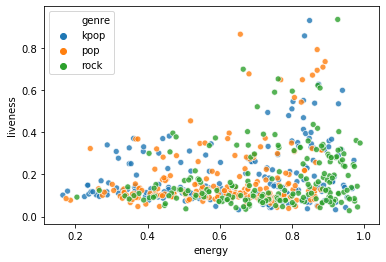

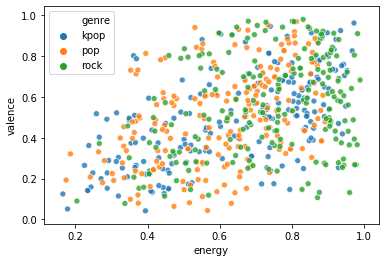

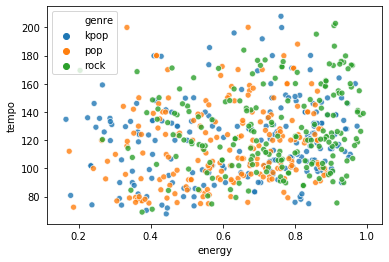

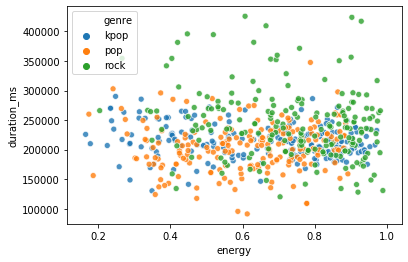

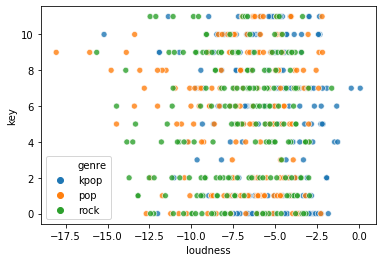

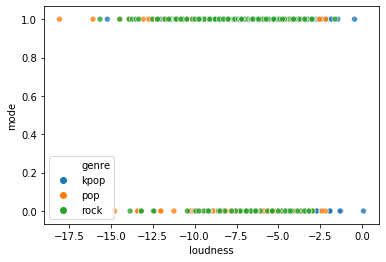

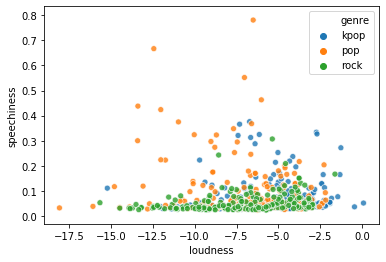

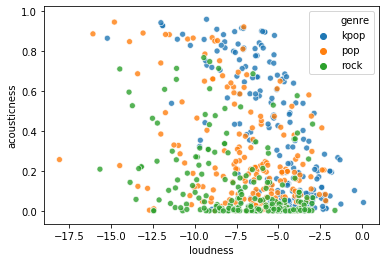

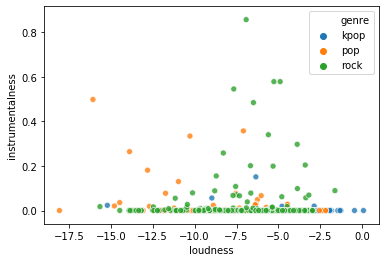

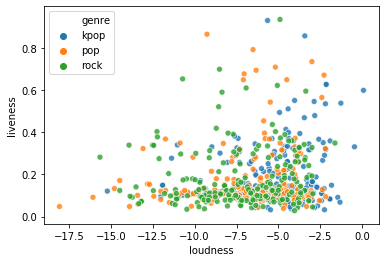

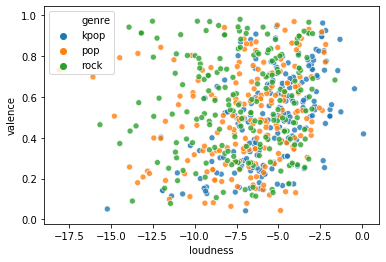

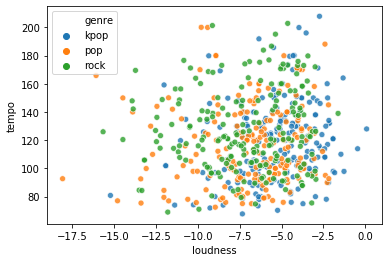

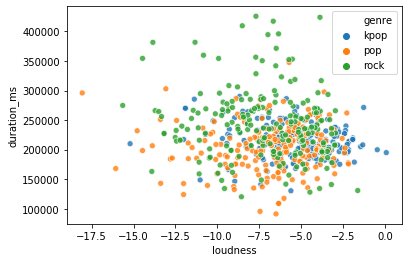

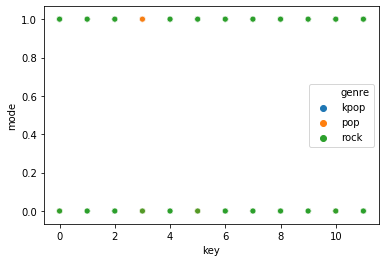

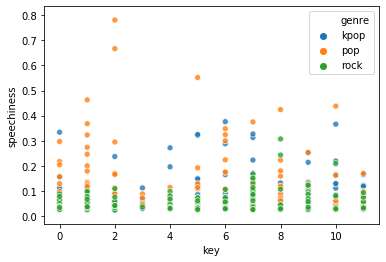

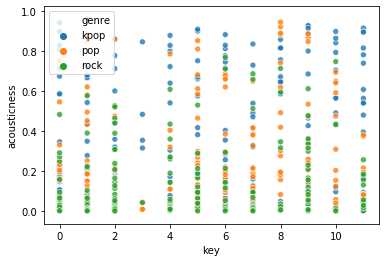

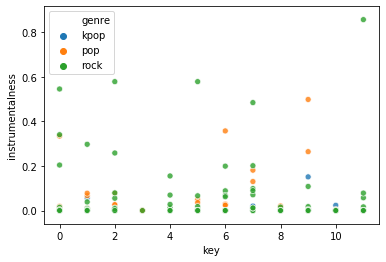

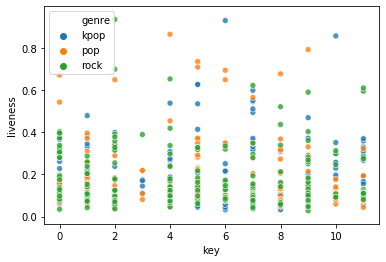

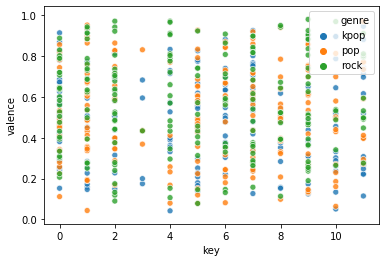

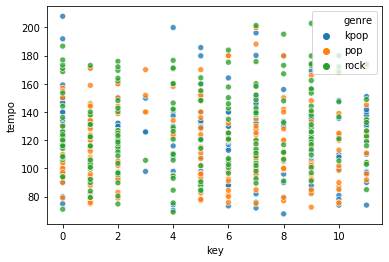

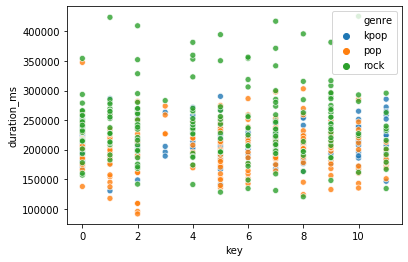

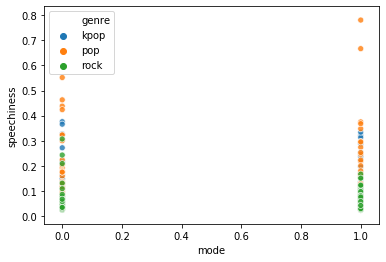

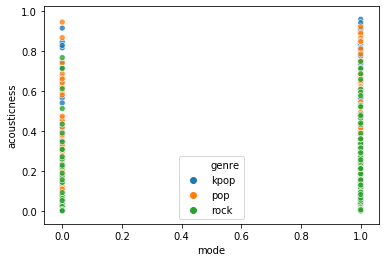

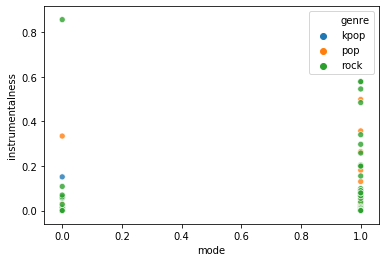

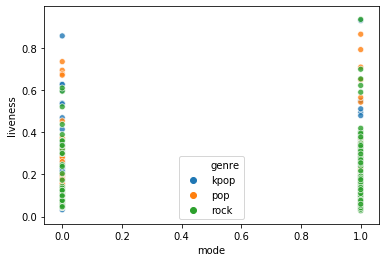

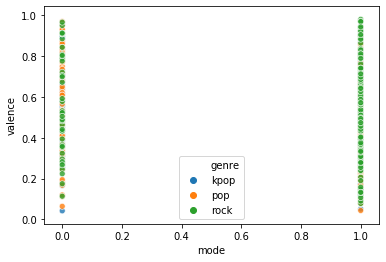

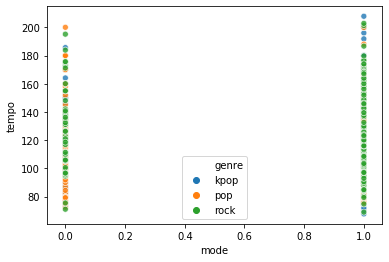

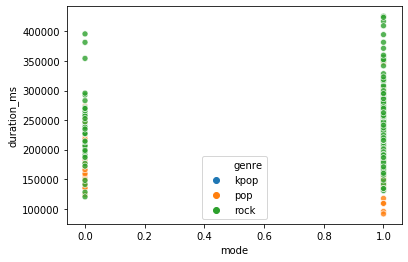

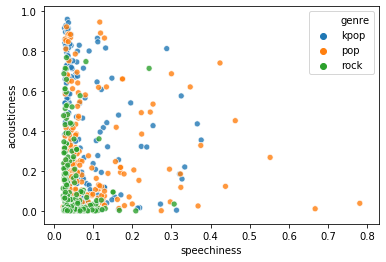

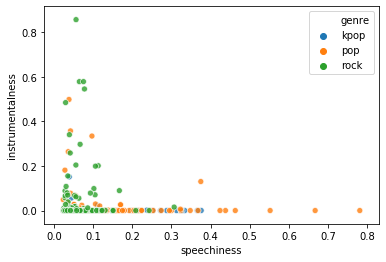

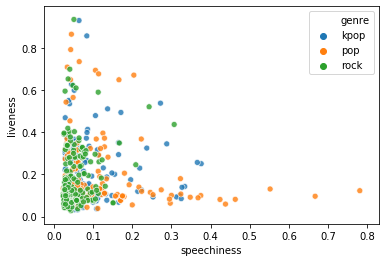

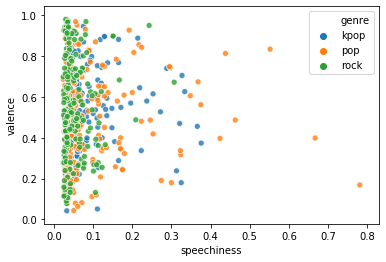

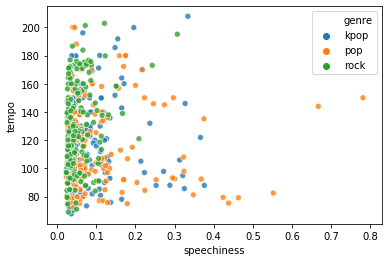

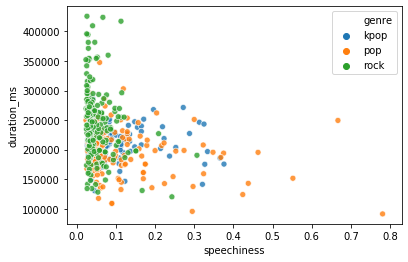

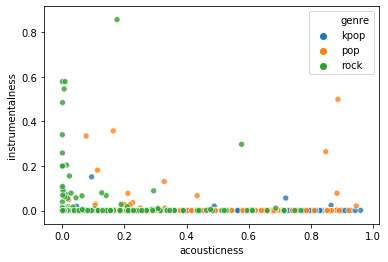

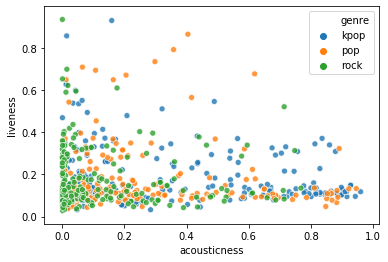

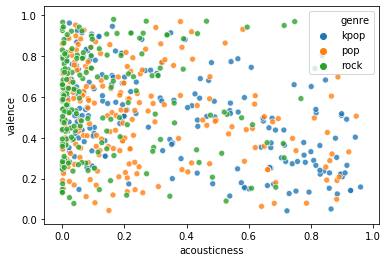

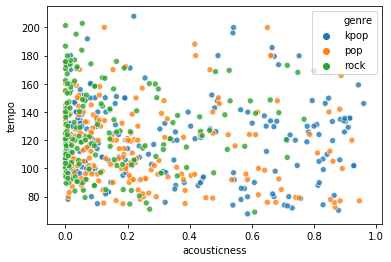

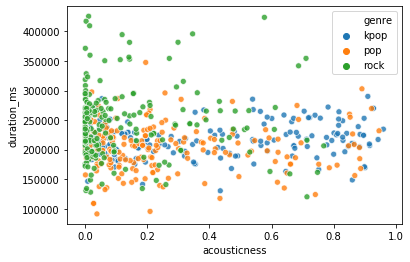

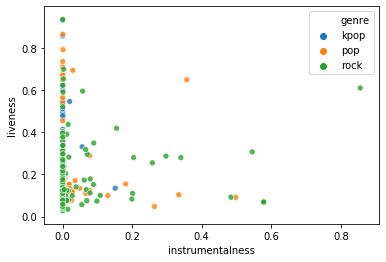

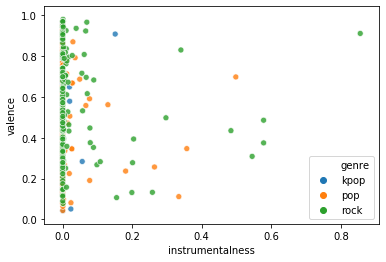

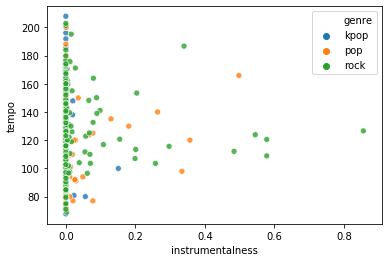

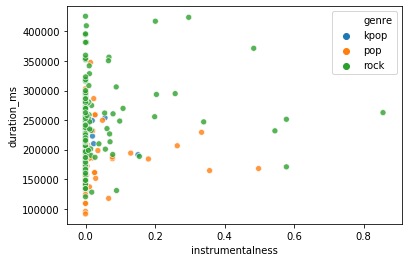

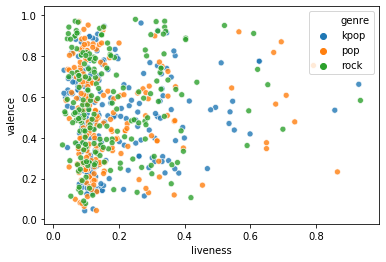

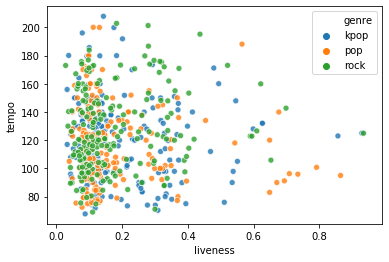

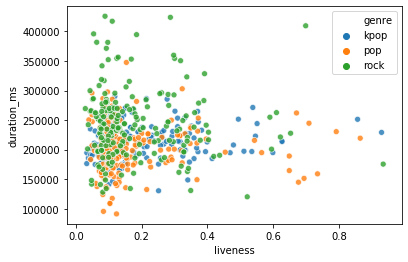

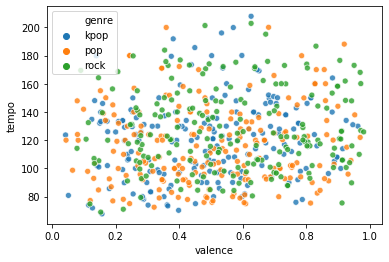

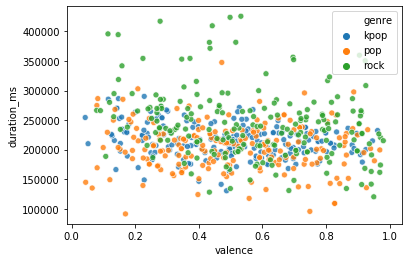

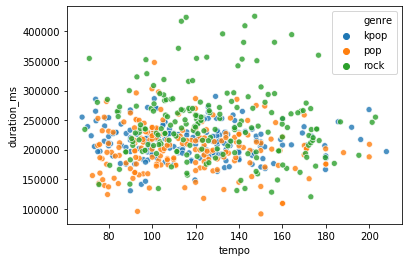

In [72]:
# sampling
import seaborn as sns
numerical_feats = ['danceability','energy','loudness','key','mode',
                   'speechiness','acousticness','instrumentalness',
                   'liveness','valence','tempo', 'duration_ms']

list_of_pairs = [(numerical_feats[f1], numerical_feats[f2]) for f1 in range(len(numerical_feats)) for f2 in range(f1+1,len(numerical_feats))]
for i in list_of_pairs:
    sns.scatterplot(x=i[0], y=i[1], hue='genre', data=analysis_df, alpha=0.8) 
    plt.show()